In [1]:
from itertools import product
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np
import torch
from torch import nn, autograd
import optimizers
import math
from tqdm import tqdm
from matplotlib import cm

# Configurations

In [2]:
np.random.seed(0)
torch.manual_seed(0)

BLUE = '#7DB1F1'
RED = '#FC82AB'
GREEN = '#7FD97B'
YELLOW = '#FFC000'
GREY = '#A5A5A5'
COLORS = [BLUE, RED, YELLOW, GREEN, '#000000']

# Jacobian, Gradient, and Auxiliary Functions

In [3]:
def dF_GD_SIM(f, lr, x, y):
    x = torch.Tensor([x]).requires_grad_()
    y = torch.Tensor([y]).requires_grad_()
    x_next = x - lr * autograd.grad(f(x, y), [x], create_graph=True)[0]
    y_next = y + lr * autograd.grad(f(x, y), [y], create_graph=True)[0]
    dxdx = autograd.grad(x_next, [x], retain_graph=True)[0]
    dxdy = autograd.grad(x_next, [y], retain_graph=True)[0]
    dydy = autograd.grad(y_next, [y], retain_graph=True)[0]
    dydx = autograd.grad(y_next, [x], retain_graph=True)[0]
    return torch.Tensor([
        [dxdx, dxdy],
        [dydx, dydy]
    ])


def dF_GD_ALT(f, lr, x, y):
    x = torch.Tensor([x]).requires_grad_()
    y = torch.Tensor([y]).requires_grad_()
    x_next = x - lr * autograd.grad(f(x, y), [x], create_graph=True)[0]
    y_next = y + lr * autograd.grad(f(x_next, y), [y], create_graph=True)[0]
    dxdx = autograd.grad(x_next, [x], retain_graph=True)[0]
    dxdy = autograd.grad(x_next, [y], retain_graph=True)[0]
    dydy = autograd.grad(y_next, [y], retain_graph=True)[0]
    dydx = autograd.grad(y_next, [x], retain_graph=True)[0]
    return torch.Tensor([
        [dxdx, dxdy],
        [dydx, dydy]
    ])


def dF_EG_SIM(f, lr, x, y):
    x = torch.Tensor([x]).requires_grad_()
    y = torch.Tensor([y]).requires_grad_()
    x_hat = x - lr * autograd.grad(f(x, y), [x], create_graph=True)[0]
    y_hat = y + lr * autograd.grad(f(x, y), [y], create_graph=True)[0]
    x_next = x - lr * autograd.grad(f(x_hat, y_hat), [x], create_graph=True)[0]
    y_next = y + lr * autograd.grad(f(x_hat, y_hat), [y], create_graph=True)[0]
    dxdx = autograd.grad(x_next, [x], retain_graph=True)[0]
    dxdy = autograd.grad(x_next, [y], retain_graph=True)[0]
    dydy = autograd.grad(y_next, [y], retain_graph=True)[0]
    dydx = autograd.grad(y_next, [x], retain_graph=True)[0]
    return torch.Tensor([
        [dxdx, dxdy],
        [dydx, dydy]
    ])


def gradient(f, x_vec, y_vec):
    x_vec = torch.Tensor(x_vec).requires_grad_()
    y_vec = torch.Tensor(y_vec).requires_grad_()
    dfdx = autograd.grad(f(x_vec, y_vec).sum(), [x_vec])[0]
    dfdy = autograd.grad(f(x_vec, y_vec).sum(), [y_vec])[0]
    return -dfdx.numpy(), dfdy.numpy()


def radius(X):
    return X.eig()[0].pow(2).sum(1).sqrt().max()


def is_local_nash(f, x, y):
    x = torch.Tensor([x]).requires_grad_()
    y = torch.Tensor([y]).requires_grad_()
    dfdx = autograd.grad(f(x, y), [x], create_graph=True)[0]
    dfdy = autograd.grad(f(x, y), [y], create_graph=True)[0]
    dfdxx = autograd.grad(dfdx, [x], retain_graph=True)[0]
    dfdxy = autograd.grad(dfdx, [y], retain_graph=True)[0]
    dfdyy = autograd.grad(dfdy, [y], retain_graph=True)[0]
    v = torch.Tensor([
        [-dfdxx, -dfdxy],
        [dfdxy, dfdyy]
    ])
    eigs = v.eig()[0]
    return (v[0][0] <= 0 and v[1][1] < 0) or (v[0][0] < 0 and v[1][1] <= 0)

    
def theta(f, dF, lr, x, y):
    return np.angle(np.linalg.eig(dF(f, lr, x, y).numpy())[0][0])


def spow(x, y):
    return x ** y

# Nonlinear Game (Eq. 9)

In [4]:
def game(x, y, eps=0.001):
    return  - torch.log(2 + torch.exp(-x * y)) + eps * (-y ** 2 / 2 + y ** 4 / 4) 

In [5]:
is_local_nash(game, 0, 0)

<ipython-input-3-9664862a9e34>:72: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448238472/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2897.)
  eigs = v.eig()[0]


tensor(True)

In [6]:
LR = 0.1
print(f'radius of GD_Alt: {radius(dF_GD_ALT(game, LR, 0, 0))}')
print(f'radius of GD_SIM: {radius(dF_GD_SIM(game, LR, 0, 0))}')
print(f'radius of EG_SIM: {radius(dF_EG_SIM(game, LR, 0, 0))}')

radius of GD_Alt: 0.9993942975997925
radius of GD_SIM: 1.0005054473876953
radius of EG_SIM: 0.9982832074165344


# Hyperparameter Sweep (GD_SIM)

<ipython-input-7-66c9a672c759>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(


theta_GD_SIM: 0.03332262486219406, rho_GD_SIM: 1.0005054473876953
=> beta1: 0.91, beta2: 176.08
=> k: [5, 19, 33, 47, 61, 75, 89, 103, 117, 131, 145, 159, 173, 187, 201, 215]
=> c: [0.8175981670971355, 0.9504778053846942, 0.9694717123701124, 0.9761452578931593, 0.9786823412773283, 0.9789572735514297, 0.9773436281410695, 0.9734264864208904, 0.9657783160083452, 0.9506538908553633, 0.9170045169000658, 0.8213795714440126, 0.35259158539431285, -15.283001489425502, -0.13156229398108818, 0.7055399571242613]
=> a: [0.95, 0.89, 0.83, 0.77, 0.71, 0.65, 0.59, 0.53, 0.47, 0.41, 0.35, 0.29, 0.23, 0.17, 0.11, 0.05]


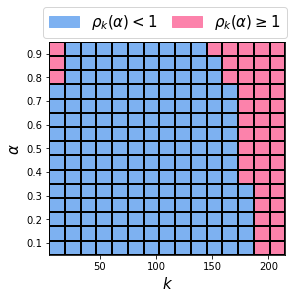

In [7]:
LR = 0.1
print(f'theta_GD_SIM: {theta(game, dF_GD_SIM, LR, 0, 0)}, rho_GD_SIM: {radius(dF_GD_SIM(game, LR, 0, 0))}')
BETA1_GD_SIM = 0.91
BETA2_GD_SIM = 176.08
GD_SIM_J = dF_GD_SIM(game, LR, 0, 0)
GD_SIM_EIG = np.linalg.eig(GD_SIM_J.numpy())[0][0]

def la_gd_sim_radius(k, alpha):
    return abs(1 - alpha + alpha * spow(GD_SIM_EIG, k))

def c_GD_SIM(k):
    return 2 * np.cos(np.angle(1-spow(GD_SIM_EIG, k))) / abs(1-spow(GD_SIM_EIG, k))

#GD_SIM_KS = list(range(5, 125 + 1, 8))
GD_SIM_KS = list(range(5, 215 + 1, 14))
GD_SIM_ALPHAS = list(reversed([x/100 for x in range(5, 95 + 1, 90 // 15)]))
GD_SIM_HPS = np.meshgrid(GD_SIM_KS, GD_SIM_ALPHAS)

gd_sim_improvements = np.array([
    1 > la_gd_sim_radius(k, alpha) for
    (k, alpha) in zip(GD_SIM_HPS[0].flatten(), GD_SIM_HPS[1].flatten())
]).reshape(GD_SIM_HPS[0].shape)
gd_sim_cs = [c_GD_SIM(k) for k in GD_SIM_KS]

edge_colors = [ ]
cmap = matplotlib.colors.ListedColormap([COLORS[1], COLORS[0]])
plt.figure(figsize=(4, 4))
plt.pcolormesh(
    GD_SIM_HPS[0], GD_SIM_HPS[1], gd_sim_improvements, 
    edgecolors='k',
    cmap=cmap,
)
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$\alpha$', fontsize=15)

# where some data has already been plotted to ax
handles, labels = plt.gca().get_legend_handles_labels()

# manually define a new patch 
patch_pos = mpatches.Patch(
    color=COLORS[0], 
    label=r'$\rho_k(\alpha)<1$'
)
patch_neg = mpatches.Patch(
    color=COLORS[1],
    label=r'$\rho_k(\alpha)\geq1$'
)
line_suff = mlines.Line2D([0], [0], color=COLORS[3], label='Thm. 7', linewidth=3)

# handles is a list, so append manual patch
handles.append(patch_pos) 
handles.append(patch_neg) 
#handles.append(line_suff)

# plot the legend
plt.legend(
    handles=handles, loc='upper center', 
    bbox_to_anchor=(-0.01, 1.20, 1.0, 0), 
    ncol=2, fontsize=15, columnspacing=1
)
plt.tight_layout(pad=0.1)
plt.savefig('./nonlinear_sweep_gd.png', format='png', dpi=200)
print(f'=> beta1: {BETA1_GD_SIM}, beta2: {BETA2_GD_SIM}')
print(f'=> k: {GD_SIM_KS}')
print(f'=> c: {gd_sim_cs}')
print(f'=> a: {GD_SIM_ALPHAS}')

# Hyperparameter Sweep (EG_SIM)

theta_EG_SIM: 0.03335302695631981, rho_EG_SIM: 0.9982832074165344


<ipython-input-8-9514033f0649>:40: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(


=> beta1: 3.0837, beta2: 166.7543
=> k: [5, 19, 33, 47, 61, 75, 89, 103, 117, 131, 145, 159, 173, 187, 201, 215]
=> c: [0.6176380416123671, 0.16771263450500495, 0.1034161932070455, 0.08084166120225865, 0.07227898614226086, 0.07138272581872973, 0.07688593742511486, 0.09017716709102407, 0.11601045284679189, 0.16667938003354088, 0.2773276071002297, 0.5755897501689441, 0.9999884995534943, 0.999994308871645, 0.99999201864508, 0.8630646860570097]
=> a: [0.95, 0.89, 0.83, 0.77, 0.71, 0.65, 0.59, 0.53, 0.47, 0.41, 0.35, 0.29, 0.23, 0.17, 0.11, 0.05]


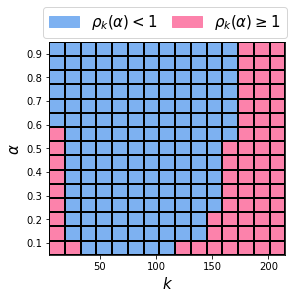

In [8]:
LR = 0.1
print(f'theta_EG_SIM: {theta(game, dF_EG_SIM, LR, 0, 0)}, rho_EG_SIM: {radius(dF_EG_SIM(game, LR, 0, 0))}')
#BETA1_EG_SIM = 3.0256
#BETA2_EG_SIM = 108.537
BETA1_EG_SIM = 3.0837
BETA2_EG_SIM = 166.7543
EG_SIM_J = dF_EG_SIM(game, LR, 0, 0)
EG_SIM_EIG = np.linalg.eig(EG_SIM_J.numpy())[0][0]

def la_eg_sim_radius(k, alpha):
    return abs(1 - alpha + alpha * spow(EG_SIM_EIG, k))

def c_EG_SIM(k):
    return (
        np.cos(np.angle(1-spow(EG_SIM_EIG, k))) -
        np.sqrt(
            abs(EG_SIM_EIG) ** (2*k) - 
            np.sin(np.angle(
                1-spow(EG_SIM_EIG, k)
            )) ** 2
        )
    ) /  abs(1-spow(EG_SIM_EIG, k))

#EG_SIM_KS = list(range(5, 125 + 1, 8))
EG_SIM_KS = list(range(5, 215 + 1, 14))
EG_SIM_ALPHAS = list(reversed([x/100 for x in range(5, 95 + 1, 90 // 15)]))
EG_SIM_HPS = np.meshgrid(EG_SIM_KS, EG_SIM_ALPHAS)


# compute
eg_sim_improvements = np.array([
    la_eg_sim_radius(k, 1) > la_eg_sim_radius(k, alpha) for
    (k, alpha) in zip(EG_SIM_HPS[0].flatten(), EG_SIM_HPS[1].flatten())
]).reshape(EG_SIM_HPS[0].shape)
eg_sim_cs = [c_EG_SIM(k) for k in EG_SIM_KS]

edge_colors = [ ]
cmap = matplotlib.colors.ListedColormap([COLORS[1], COLORS[0]])
plt.figure(figsize=(4, 4))
plt.pcolormesh(
    EG_SIM_HPS[0], EG_SIM_HPS[1], eg_sim_improvements, 
    edgecolors='k',
    cmap=cmap,
)
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$\alpha$', fontsize=15)

# where some data has already been plotted to ax
handles, labels = plt.gca().get_legend_handles_labels()

# manually define a new patch 
patch_pos = mpatches.Patch(
    color=COLORS[0], 
    label=r'$\rho_k(\alpha)<1$'
)
patch_neg = mpatches.Patch(
    color=COLORS[1],
    label=r'$\rho_k(\alpha)\geq1$'
)
line_suff = mlines.Line2D([0], [0], color=COLORS[3], label='Thm. 7', linewidth=3)

# handles is a list, so append manual patch
handles.append(patch_pos) 
handles.append(patch_neg) 
#handles.append(line_suff)

# plot the legend
plt.legend(
    handles=handles, loc='upper center', 
    bbox_to_anchor=(-0.01, 1.20, 1.0, 0), 
    ncol=2, fontsize=15, columnspacing=1
)
plt.tight_layout(pad=0.1)
plt.savefig('./nonlinear_sweep_eg.png', format='png', dpi=200)
print(f'=> beta1: {BETA1_EG_SIM}, beta2: {BETA2_EG_SIM}')
print(f'=> k: {EG_SIM_KS}')
print(f'=> c: {eg_sim_cs}')
print(f'=> a: {EG_SIM_ALPHAS}')

# Optimization

In [9]:
def run(game, opt_name, lr, init, goal, k=None, alpha=None, alt=False, momentum=0, log_every=25, niter=1500):
    x1 = nn.Parameter(init[0].clone(), requires_grad=True)
    x2 = nn.Parameter(init[1].clone(), requires_grad=True)
    x1_optimizer = getattr(optimizers, opt_name)([x1], lr=lr, momentum=momentum)
    x2_optimizer = getattr(optimizers, opt_name)([x2], lr=lr, momentum=momentum)
    la = (
        optimizers.Lookahead(
            x1_optimizer, 
            x2_optimizer, 
            k=k, alpha=alpha,  
            device='cpu'
        ) if k and alpha is not None else None
    )
    
    def distance(x1, x2):
        return ((x1 - goal[0]) ** 2 + (x2 - goal[1]) ** 2).sqrt()
    
    x1_history = []
    x2_history = []
    d_history = []
    for t in tqdm(range(1, niter + 1)):
        if t % log_every == 1:
            x1_history.append(x1.data.detach().clone().cpu().numpy()) 
            x2_history.append(x2.data.detach().clone().cpu().numpy()) 
            d_history.append(distance(x1, x2).detach().cpu().numpy())
        
        if alt:
            # x1
            x1_optimizer.zero_grad()
            (game(x1, x2)).backward()
            x1_optimizer.step()
            # x2
            x2_optimizer.zero_grad()
            (-game(x1, x2)).backward()
            x2_optimizer.step()
        else:
            x1_optimizer.zero_grad()
            x2_optimizer.zero_grad()
            game(x1, x2.detach()).backward()
            (-game(x1.detach(), x2)).backward()
            if opt_name == 'ExtraSGD':
                x1_optimizer.extrapolation()
                x2_optimizer.extrapolation()
                x1_optimizer.zero_grad()
                x2_optimizer.zero_grad()
                game(x1, x2.detach()).backward()
                (-game(x1.detach(), x2)).backward()
            x1_optimizer.step()
            x2_optimizer.step()
        if la:
            la.step()
    return np.array(d_history), np.array(x1_history).squeeze(), np.array(x2_history).squeeze()

# Stabilization

In [10]:
# =============
# stabilization
# =============

init_stabilization = torch.Tensor([2.5, -1])
goal = torch.Tensor([0, 0])
T = 1500
k = 50
log_every=k
alpha = 0.3
LR = 0.1
NM = -0.2

gd_sim_histories = run(game, 'SGD', lr=LR, init=init_stabilization, goal=(0, 0), log_every=log_every, niter=T)
nm_gd_sim_histories = run(game, 'SGD', lr=LR, init=init_stabilization, goal=(0, 0), log_every=log_every, niter=T, momentum=NM)
la_nm_gd_sim_histories = run(game, 'SGD', lr=LR, init=init_stabilization, goal=(0, 0), k=k, alpha=alpha, log_every=log_every, niter=T, momentum=NM)
la_gd_sim_histories = run(game, 'SGD', lr=LR, init=init_stabilization, goal=(0, 0), k=k, alpha=alpha, log_every=log_every, niter=T)

  0%|          | 0/1500 [00:00<?, ?it/s]/home_namjune/junsoo.ha/aistats-supp/optimizers/gd.py:106: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448238472/work/torch/csrc/utils/python_arg_parser.cpp:1025.)
  p.data.add_(-group['lr'], d_p)
100%|██████████| 1500/1500 [00:00<00:00, 2028.05it/s]


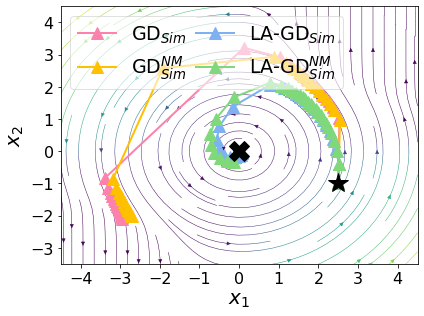

In [11]:
plt.figure(figsize=(6, 4.5))

plt.plot(
    gd_sim_histories[1].squeeze(),
    gd_sim_histories[2].squeeze(),
    label=r'GD$_{Sim}$',
    color=RED,
    linewidth=2,
    markersize=12,
    marker='^'
)
plt.plot(
    nm_gd_sim_histories[1].squeeze(),
    nm_gd_sim_histories[2].squeeze(),
    label=r'GD$^{NM}_{Sim}$',
    color=YELLOW,
    linewidth=2,
    markersize=12,
    marker='^',
)

plt.plot(
    la_gd_sim_histories[1].squeeze(),
    la_gd_sim_histories[2].squeeze(),
    label=r'LA-GD$_{Sim}$',
    color=BLUE,
    linewidth=2,
    markersize=12,
    marker='^'
)
plt.plot(
    la_nm_gd_sim_histories[1].squeeze(),
    la_nm_gd_sim_histories[2].squeeze(),
    label=r'LA-GD$^{NM}_{Sim}$',
    color=GREEN,
    linewidth=2,
    markersize=12,
    marker='^',
)

XLIM = 4.5
YLIM = 4.5
plt.xlim(-XLIM, XLIM)
plt.ylim(-YLIM + 1, YLIM)
plt.xlabel(r'${x_1}$', fontsize=20)
plt.ylabel(r'${x_2}$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(
    loc='upper left', ncol=2, fontsize=19, 
    columnspacing=0.5, 
    framealpha=0.6,
)

STREAM_K = 100
STREAM_LINE_WIDTH = 0.5
STREAM_DENSITY = 1.1
STREAM_ARROW_SIZE = 0.8
GRID_X1, GRID_X2 = np.meshgrid(
    np.linspace(-XLIM, XLIM, STREAM_K),
    np.linspace(-YLIM, YLIM, STREAM_K)
)
GRAD_X1, GRAD_X2 = gradient(game, GRID_X1, GRID_X2)
STREAM_COLOR = (np.hypot(GRAD_X1, GRAD_X2)) + 30
plt.streamplot(
    GRID_X1, GRID_X2, GRAD_X1, GRAD_X2, 
    color=STREAM_COLOR, 
    cmap=cm.viridis,
    linewidth=STREAM_LINE_WIDTH,  
    density=STREAM_DENSITY, 
    arrowstyle='-|>', 
    arrowsize=STREAM_ARROW_SIZE
)
plt.plot(init_stabilization[0], init_stabilization[1], marker='*',  markersize=20, color='black')
plt.plot(goal[0], goal[1], marker='X',  markersize=20, color='black')
plt.tight_layout()
plt.savefig('nonlinear_stabilization_trajectory.png', format='png', bbox_inches='tight', dpi=300)

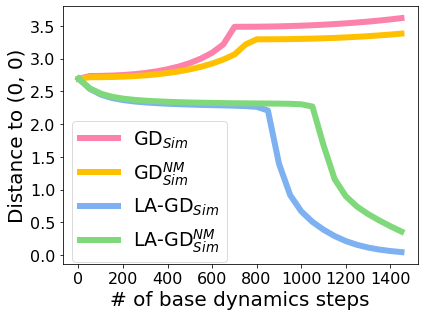

In [12]:
plt.figure(figsize=(6, 4.5))

LINEWIDTH = 6

plt.plot(
    np.arange(1, T+1, step=log_every), gd_sim_histories[0][:1000], 
    label=r'GD$_{Sim}$', 
    color=RED,
    linewidth=LINEWIDTH
)
plt.plot(
    np.arange(1, T+1, step=log_every), nm_gd_sim_histories[0], 
    label=r'GD$^{NM}_{Sim}$', 
    color=YELLOW,
    linewidth=LINEWIDTH
)

plt.plot(
    np.arange(1, T+1, step=log_every), la_gd_sim_histories[0], 
    label=r'LA-GD$_{Sim}$', 
    color=BLUE,
    linewidth=LINEWIDTH
)
plt.plot(
    np.arange(1, T+1, step=log_every), la_nm_gd_sim_histories[0], 
    label=r'LA-GD$^{NM}_{Sim}$', 
    color=GREEN,
    linewidth=LINEWIDTH
)

plt.xlabel('# of base dynamics steps', fontsize=20)
plt.ylabel('Distance to (0, 0)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='lower left', ncol=1, columnspacing=0.5, fontsize=19, framealpha=0.7, bbox_to_anchor=(0, -0.03))
plt.tight_layout()
plt.savefig('nonlinear_stabilization_progress.png', format='png', bbox_inches='tight', dpi=300)

# Acceleration

In [13]:
# =============
# acceleration
# =============

init_acceleration = torch.Tensor([1.8, -1.2])
LR = 0.1
T = 1500
k = 50
log_every=k
alpha = 0.7
NM = -0.9

eg_sim_histories = run(game, 'ExtraSGD', lr=LR, init=init_acceleration, goal=(0, 0), log_every=log_every, niter=T)
nm_gd_alt_histories = run(game, 'SGD', lr=LR, init=init_acceleration, goal=(0, 0), log_every=log_every, niter=T, alt=True, momentum=NM)
la_gd_alt_histories = run(game, 'SGD', lr=LR, init=init_acceleration, goal=(0, 0), k=k, alpha=alpha, log_every=log_every, niter=T, alt=True, momentum=NM)
la_eg_sim_histories = run(game, 'ExtraSGD', lr=LR, init=init_acceleration, goal=(0, 0), k=k, alpha=alpha, log_every=log_every, niter=T)

100%|██████████| 1500/1500 [00:01<00:00, 1030.07it/s]


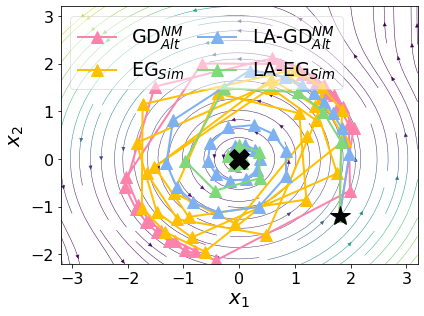

In [14]:
plt.figure(figsize=(6, 4.5))

plt.plot(
    nm_gd_alt_histories[1].squeeze(),
    nm_gd_alt_histories[2].squeeze(),
    label=r'GD$^{NM}_{Alt}$',
    color=RED,
    linewidth=2,
    markersize=12,
    marker='^'
)
plt.plot(
    eg_sim_histories[1].squeeze(),
    eg_sim_histories[2].squeeze(),
    label=r'EG$_{Sim}$',
    color=YELLOW,
    linewidth=2,
    markersize=12,
    marker='^'
)
plt.plot(
    la_gd_alt_histories[1].squeeze(),
    la_gd_alt_histories[2].squeeze(),
    label=r'LA-GD$^{NM}_{Alt}$',
    color=BLUE,
    linewidth=2,
    markersize=12,
    marker='^'
)
plt.plot(
    la_eg_sim_histories[1].squeeze(),
    la_eg_sim_histories[2].squeeze(),
    label=r'LA-EG$_{Sim}$',
    color=GREEN,
    linewidth=2,
    markersize=12,
    marker='^'
)

XLIM = 3.2
YLIM = 3.2
plt.xlim(-XLIM, XLIM)
plt.ylim(-YLIM + 1, YLIM)
plt.xlabel(r'${x_1}$', fontsize=20)
plt.ylabel(r'${x_2}$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper left', ncol=2, fontsize=19, columnspacing=0.75, framealpha=0.5)

STREAM_K = 100
STREAM_LINE_WIDTH = 0.5
STREAM_DENSITY = 1.1
STREAM_ARROW_SIZE = 0.8
GRID_X1, GRID_X2 = np.meshgrid(
    np.linspace(-XLIM, XLIM, STREAM_K),
    np.linspace(-YLIM, YLIM, STREAM_K)
)
GRAD_X1, GRAD_X2 = gradient(game, GRID_X1, GRID_X2)
STREAM_COLOR = (np.hypot(GRAD_X1, GRAD_X2)) + 30
plt.streamplot(
    GRID_X1, GRID_X2, GRAD_X1, GRAD_X2, 
    color=STREAM_COLOR, 
    cmap=cm.viridis,
    linewidth=STREAM_LINE_WIDTH,  
    density=STREAM_DENSITY, 
    arrowstyle='-|>', 
    arrowsize=STREAM_ARROW_SIZE
)
plt.plot(init_acceleration[0], init_acceleration[1], marker='*',  markersize=20, color='black')
plt.plot(goal[0], goal[1], marker='X',  markersize=20, color='black')
plt.tight_layout()
plt.savefig('nonlinear_acceleration_trajectory.png', format='png', bbox_inches='tight', dpi=300)

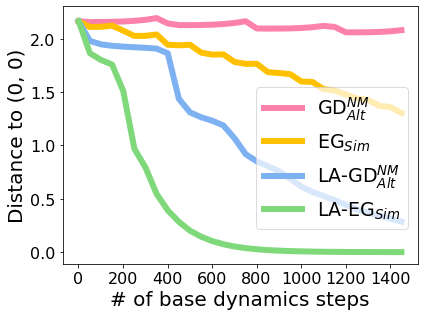

In [15]:
plt.figure(figsize=(6, 4.5))

LINEWIDTH = 6

plt.plot(
    np.arange(1, T+1, step=log_every), nm_gd_alt_histories[0], 
    label=r'GD$^{NM}_{Alt}$', 
    color=RED,
    linewidth=LINEWIDTH
)
plt.plot(
    np.arange(1, T+1, step=log_every), eg_sim_histories[0], 
    label=r'EG$_{Sim}$', 
    color=YELLOW,
    linewidth=LINEWIDTH
)

plt.plot(
    np.arange(1, T+1, step=log_every), la_gd_alt_histories[0], 
    label=r'LA-GD$^{NM}_{Alt}$', 
    color=BLUE,
    linewidth=LINEWIDTH
)
plt.plot(
    np.arange(1, T+1, step=log_every), la_eg_sim_histories[0], 
    label=r'LA-EG$_{Sim}$', 
    color=GREEN,
    linewidth=LINEWIDTH
)

plt.xlabel('# of base dynamics steps', fontsize=20)
plt.ylabel('Distance to (0, 0)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='lower right', ncol=1, columnspacing=0.5, fontsize=19, bbox_to_anchor=(1, 0.1), framealpha=0.7)
plt.tight_layout()
plt.savefig('nonlinear_acceleration_progress.png', format='png', bbox_inches='tight', dpi=300)